<a href="https://colab.research.google.com/github/3-Ada/image_classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intel Image Classification

## Step 0: import dataset from Kaggle

In [1]:
from google.colab import files # library for working with files

In [2]:
files.upload() # upload kaggle.json from pc

!pip install -q kaggle # install kaggle API client

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle # create folder with name .kaggle
! cp kaggle.json ~/.kaggle/ # move kaggle.json to created directory
! chmod 600 /root/.kaggle/kaggle.json # change permissions to more secure

In [4]:
! kaggle datasets download -d puneet6060/intel-image-classification

 95% 329M/346M [00:02<00:00, 58.0MB/s]
100% 346M/346M [00:02<00:00, 133MB/s] 


In [5]:
# for not showing output
%%capture
! mkdir /content/image_files
! unzip intel-image-classification.zip -d /content/image_files

## Step 1: explore the dataset

In [6]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

In [7]:
root_dir = "/content/image_files/seg_train/seg_train/"
sub_folders = os.listdir(root_dir)
labels = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4,
          'street': 5}

data = []

for s, l in labels.items():
    for r, d, f in os.walk(root_dir + s):
        for file in f:
            if ".jpg" in file:
                data.append((os.path.join(s,file), l, s))

df_images_info = pd.DataFrame(data, columns=['file_name', 'label', 'category'])

In [8]:
df_images_info.head()

,file_name,label,category
0,buildings/10362.jpg,0,buildings
1,buildings/1859.jpg,0,buildings
2,buildings/10699.jpg,0,buildings
3,buildings/5638.jpg,0,buildings
4,buildings/17977.jpg,0,buildings


In [9]:
df_images_info.shape

(14034, 3)

The dataset contains 14 034 images.

Text(0.5, 1.0, 'Amount of images in each category')

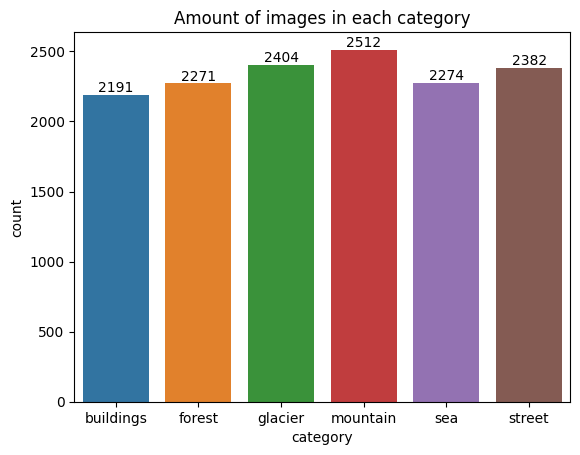

In [10]:
ax = sns.countplot(data=df_images_info, x='category')
ax.bar_label(ax.containers[0])
ax.set_title("Amount of images in each category")

As we can see, the dataset is pretty balanced.

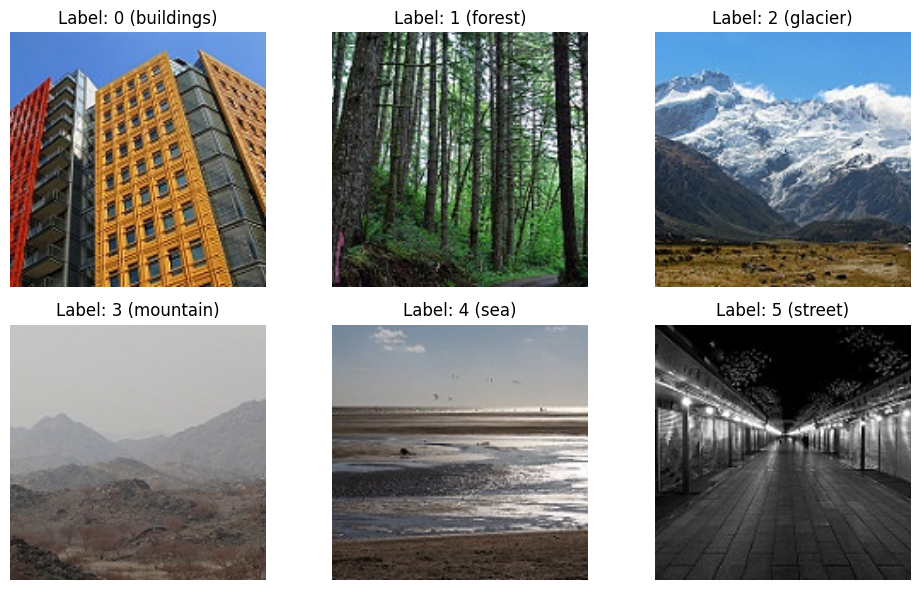

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

index = 0
for i in range(2):
    for j in range(3):

        label = df_images_info['label'][index]
        category = df_images_info['category'][index]
        file_path = os.path.join(root_dir, df_images_info.file_name[index])

        # read an image with OpenCV
        image = cv2.imread(file_path)

        # convert the image to RGB color space.
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # resize image
        image = cv2.resize(image, (256, 256))

        ax[i,j].imshow(image)
        ax[i,j].set_title(f"Label: {label} ({category})")
        ax[i,j].axis('off')
        # add to the index amount of images in category
        index += len(df_images_info[df_images_info['category'] == category])

plt.tight_layout()
plt.show()

## Step 2: prepare the model

In [12]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.4 MB/s eta 0:00:00


In [14]:
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm

from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

In [34]:
class CustomDataset(Dataset):
    def __init__(self, df):

      self.root_dir = root_dir
      self.df = df
      self.file_names = df['file_name'].values
      self.labels = df['label'].values

      self.transform = A.Compose([A.Resize(image_size, image_size),
                                  ToTensorV2(),])

    def __len__(self):
      return len(self.df)

    def __getitem__(self, index): # Get sample from dataset

      label = self.labels[index]
      file_path = os.path.join(self.root_dir, self.file_names[index])

      # read an image with OpenCV
      image = cv2.imread(file_path)

      # convert the image to RGB color space.
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      # apply transformation
      transformed = self.transform(image=image)
      image = transformed['image']

      # normalize because ToTensorV2() doesn't normalize the image
      image = image/255

      return image, label

In [35]:
def train_one_epoch(dataloader, model, optimizer, scheduler):
  # training mode
  model.train()

  final_y = []
  final_y_pred = []
  final_loss = []

  for step, batch in enumerate(dataloader):
      X = batch[0].to(device)
      y = batch[1].to(device)

      # zero the parameter gradients
      optimizer.zero_grad()

      with torch.set_grad_enabled(True):

          y_pred = model(X)

          loss = criterion(y_pred, y)

          # convert y and y_pred to lists
          y =  y.detach().to(device).cpu().numpy().tolist()
          y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

          final_y.extend(y)
          final_y_pred.extend(y_pred)
          final_loss.append(loss.item())

          # optimize
          loss.backward()
          optimizer.step()

      scheduler.step()

  # calculate statistics
  loss = np.mean(final_loss)
  final_y_pred = np.argmax(final_y_pred, axis=1)
  metric = accuracy_score(final_y, final_y_pred)

  return metric, loss

In [27]:
def validate_one_epoch(dataloader, model):
  # validation mode
  model.eval()

  final_y = []
  final_y_pred = []
  final_loss = []

  for step, batch in enumerate(dataloader):
      X = batch[0].to(device)
      y = batch[1].to(device)

      with torch.no_grad():
          y_pred = model(X)

          loss = criterion(y_pred, y)

          # convert y and y_pred to lists
          y =  y.detach().to(device).cpu().numpy().tolist()
          y_pred =  y_pred.detach().to(device).cpu().numpy().tolist()

          # extend original list
          final_y.extend(y)
          final_y_pred.extend(y_pred)
          final_loss.append(loss.item())

  # calculate statistics
  loss = np.mean(final_loss)
  final_y_pred = np.argmax(final_y_pred, axis=1)
  metric = accuracy_score(final_y, final_y_pred)

  return metric, loss

In [28]:
# fit model for all epochs
def fit(model, optimizer, scheduler, train_dataloader, valid_dataloader=None):
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        acc, loss = train_one_epoch(train_dataloader, model, optimizer, scheduler)

        print(f'Train Loss: {loss:.4f} Train Accuracy: {acc:.4f}')
        acc_list.append(acc)
        loss_list.append(loss)

        if valid_dataloader != None:
            val_acc, val_loss = validate_one_epoch(valid_dataloader, model)
            print(f'Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}')
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)

    return acc_list, loss_list, val_acc_list, val_loss_list, model

In [29]:
def visualize_history(acc, loss, val_acc, val_loss):
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    ax[0].plot(range(len(loss)), loss, label = 'train')
    ax[0].plot(range(len(val_loss)), val_loss, label = 'valid')
    ax[0].set_title('Loss')

    ax[1].plot(range(len(acc)), acc, label = 'train')
    ax[1].plot(range(len(val_acc)), val_acc, label = 'valid')
    ax[1].set_title('Metric (Accuracy)')

    for i in range(2):
        ax[i].set_xlabel('Epochs')
        ax[i].legend(loc="upper right")
    plt.show()

In [30]:
image_size = 256
batch_size = 32

# if GPU is avalaible training will be conducted on it, if not use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_folds = 5

n_classes = len(df_images_info.label.unique())
backbone = 'resnet18'

learning_rate = 1e-4

epochs = 5
lr_min = 1e-5

In [31]:
# Create a new column for cross-validation folds
df_images_info["kfold"] = -1

# Initialize the kfold class
skf = StratifiedKFold(n_splits=n_folds)

# Fill the new column
for fold, (train_, val_) in enumerate(skf.split(X = df_images_info, y = df_images_info.label)):
      df_images_info.loc[val_ , "kfold"] = fold

for fold in range(n_folds):
    train_df = df_images_info[df_images_info.kfold != fold].reset_index(drop=True)
    valid_df = df_images_info[df_images_info.kfold == fold].reset_index(drop=True)

Epoch 1/5
Train Loss: 0.8160 Train Accuracy: 0.7816
Validation Loss: 0.2883 Validation Acc: 0.9099
Epoch 2/5
Train Loss: 0.2859 Train Accuracy: 0.9062
Validation Loss: 0.2285 Validation Acc: 0.9259
Epoch 3/5
Train Loss: 0.2249 Train Accuracy: 0.9262
Validation Loss: 0.2114 Validation Acc: 0.9302
Epoch 4/5
Train Loss: 0.1894 Train Accuracy: 0.9390
Validation Loss: 0.2054 Validation Acc: 0.9312
Epoch 5/5
Train Loss: 0.1777 Train Accuracy: 0.9430
Validation Loss: 0.2034 Validation Acc: 0.9302


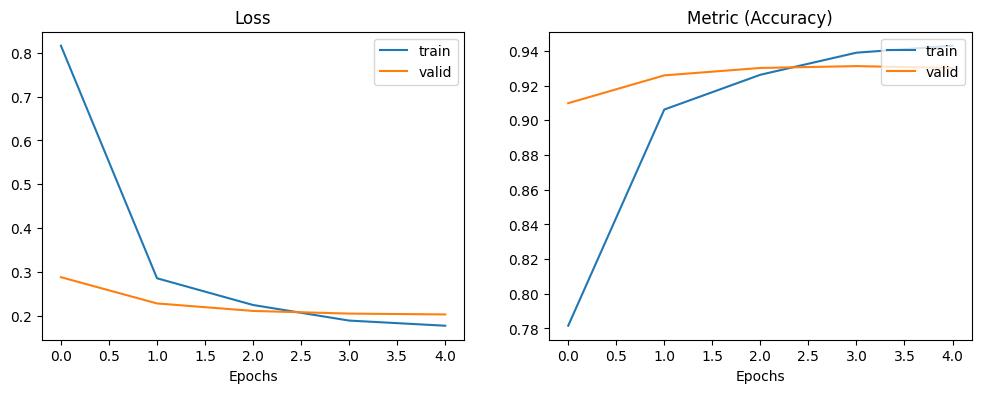

Epoch 1/5
Train Loss: 0.7842 Train Accuracy: 0.7889
Validation Loss: 0.2713 Validation Acc: 0.9202
Epoch 2/5
Train Loss: 0.2836 Train Accuracy: 0.9078
Validation Loss: 0.2197 Validation Acc: 0.9259
Epoch 3/5
Train Loss: 0.2243 Train Accuracy: 0.9245
Validation Loss: 0.1938 Validation Acc: 0.9341
Epoch 4/5
Train Loss: 0.1951 Train Accuracy: 0.9358
Validation Loss: 0.1903 Validation Acc: 0.9344
Epoch 5/5
Train Loss: 0.1803 Train Accuracy: 0.9401
Validation Loss: 0.1882 Validation Acc: 0.9352


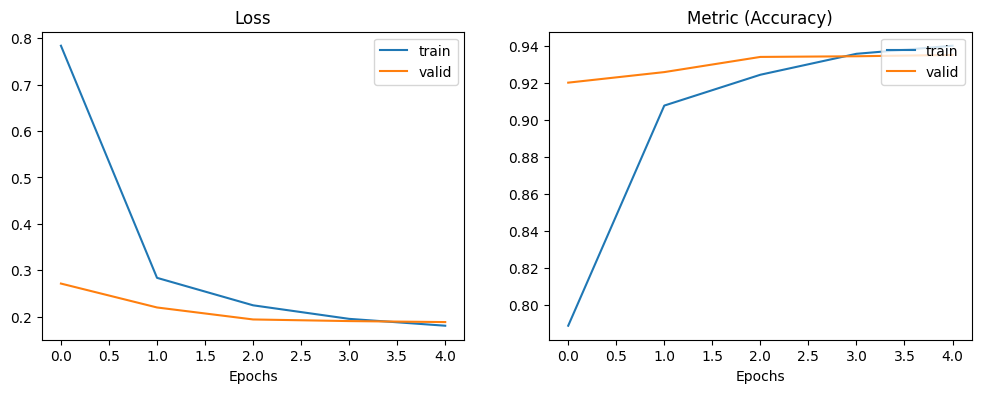

Epoch 1/5
Train Loss: 0.7912 Train Accuracy: 0.7972
Validation Loss: 0.2785 Validation Acc: 0.9149
Epoch 2/5
Train Loss: 0.2836 Train Accuracy: 0.9099
Validation Loss: 0.2244 Validation Acc: 0.9177
Epoch 3/5
Train Loss: 0.2282 Train Accuracy: 0.9250
Validation Loss: 0.1992 Validation Acc: 0.9295
Epoch 4/5
Train Loss: 0.1937 Train Accuracy: 0.9368
Validation Loss: 0.1916 Validation Acc: 0.9305
Epoch 5/5
Train Loss: 0.1803 Train Accuracy: 0.9413
Validation Loss: 0.1901 Validation Acc: 0.9323


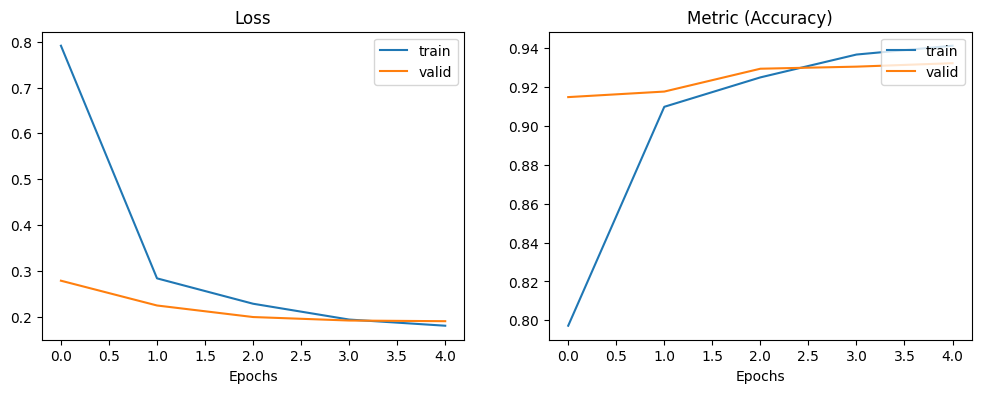

Epoch 1/5
Train Loss: 0.7971 Train Accuracy: 0.7813
Validation Loss: 0.3148 Validation Acc: 0.8956
Epoch 2/5
Train Loss: 0.2859 Train Accuracy: 0.9067
Validation Loss: 0.2232 Validation Acc: 0.9245
Epoch 3/5
Train Loss: 0.2158 Train Accuracy: 0.9306
Validation Loss: 0.2113 Validation Acc: 0.9302
Epoch 4/5
Train Loss: 0.1901 Train Accuracy: 0.9368
Validation Loss: 0.2077 Validation Acc: 0.9291
Epoch 5/5
Train Loss: 0.1752 Train Accuracy: 0.9420
Validation Loss: 0.2037 Validation Acc: 0.9298


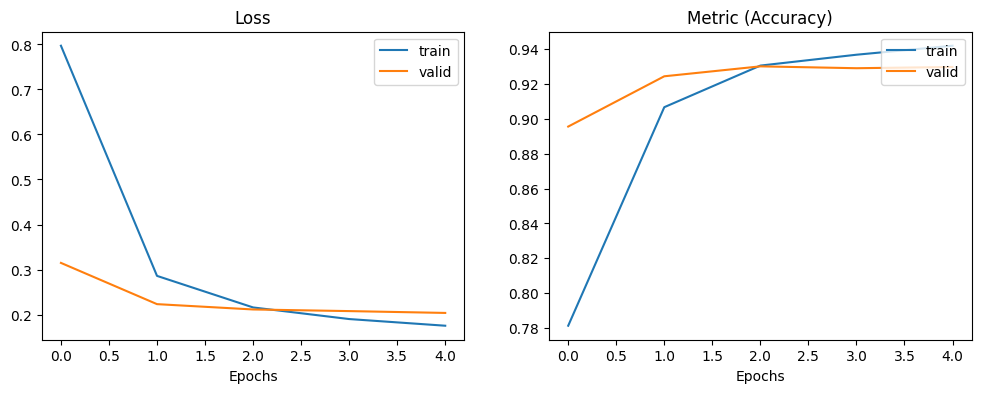

Epoch 1/5
Train Loss: 0.8250 Train Accuracy: 0.7738
Validation Loss: 0.3051 Validation Acc: 0.9070
Epoch 2/5
Train Loss: 0.2938 Train Accuracy: 0.9028
Validation Loss: 0.2460 Validation Acc: 0.9205
Epoch 3/5
Train Loss: 0.2256 Train Accuracy: 0.9253
Validation Loss: 0.2139 Validation Acc: 0.9255
Epoch 4/5
Train Loss: 0.1945 Train Accuracy: 0.9356
Validation Loss: 0.2079 Validation Acc: 0.9284
Epoch 5/5
Train Loss: 0.1802 Train Accuracy: 0.9419
Validation Loss: 0.2065 Validation Acc: 0.9298


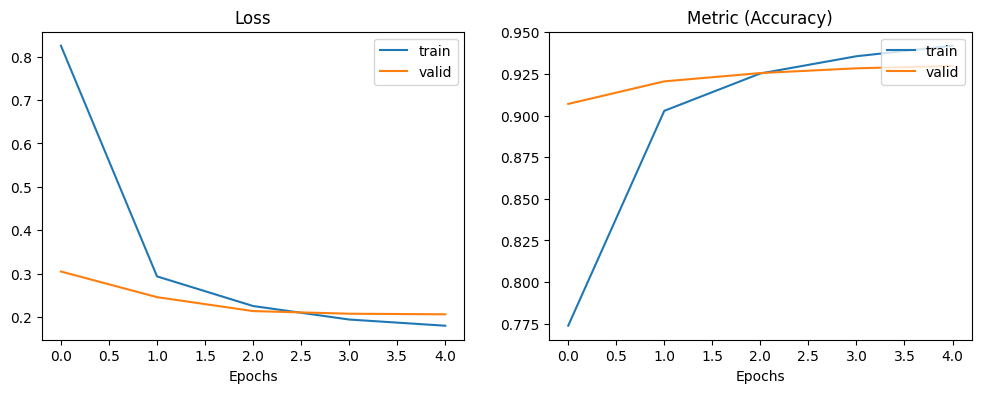

In [36]:
for fold in range(n_folds):
  train_df = df_images_info[df_images_info.kfold != fold].reset_index(drop=True)
  valid_df = df_images_info[df_images_info.kfold == fold].reset_index(drop=True)

  train_dataset = CustomDataset(train_df)
  valid_dataset = CustomDataset(valid_df)

  train_dataloader = DataLoader(train_dataset,
                      batch_size = batch_size,
                      shuffle = True)
  valid_dataloader = DataLoader(valid_dataset,
                      batch_size = batch_size,
                      shuffle = False)


  model = timm.create_model(backbone,
                      pretrained = True,
                      num_classes = n_classes)

  model = model.to(device)

  criterion = nn.CrossEntropyLoss()


  optimizer = torch.optim.Adam(model.parameters(),
                        lr = learning_rate,
                        weight_decay = 0,)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                         T_max= np.ceil(len(train_dataloader.dataset) / batch_size) * epochs,
                                                         eta_min=lr_min)

  acc, loss, val_acc, val_loss, model = fit(model, optimizer, scheduler, train_dataloader, valid_dataloader)

  visualize_history(acc, loss, val_acc, val_loss)


## Step 3: run expirements